In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Cell 2: Load and preprocess data
def load_and_preprocess_data(movies_path, user_history_path):
    # Load datasets
    movies_df = pd.read_csv(movies_path, sep=';', dtype=str)
    user_history_df = pd.read_csv(user_history_path, sep=';', dtype=str)

    movies_df = movies_df[~movies_df.apply(lambda row: row.astype(str).str.contains('Unknown').any(), axis=1)]
    
    print(f"Movies dataset shape: {movies_df.shape}")
    print(f"User history dataset shape: {user_history_df.shape}")
    
    # Preprocess movie features
    # Handle multiple entries in genres and cast
    movies_df['Genres'] = movies_df['Genres'].str.split(',')
    movies_df['Director'] = movies_df['Director'].str.split(',')
    movies_df['Cast'] = movies_df['Cast'].str.split(',')
    
    # Convert year to numeric
    movies_df['Year'] = pd.to_numeric(movies_df['Year'], errors='coerce')
    
    # Normalize numerical features
    scaler = MinMaxScaler()
    movies_df[['Year', 'RunningTime', 'Rating', 'Votes']] = scaler.fit_transform(
        movies_df[['Year', 'RunningTime', 'Rating', 'Votes']].fillna(0)
    )
    
    # Encode categorical features
    genre_encoder = LabelEncoder()
    director_encoder = LabelEncoder()
    cast_encoder = LabelEncoder()
    
    # Extract unique values
    all_genres = [genre for genres_list in movies_df['Genres'].dropna() for genre in genres_list]
    all_directors = [director for director_list in movies_df['Director'].dropna() for director in director_list]
    all_cast = [actor for cast_list in movies_df['Cast'].dropna() for actor in cast_list]
    
    # Fit encoders
    genre_encoder.fit(list(set(all_genres)))
    director_encoder.fit(list(set(all_directors)))
    cast_encoder.fit(list(set(all_cast)))
    
    return movies_df, user_history_df, genre_encoder, director_encoder, cast_encoder

In [3]:
# Cell 3: Data exploration
# Paths to your data files - update these paths
movies_path = "data/data.csv"
user_history_path = "data/user_data.csv"

# Load and preprocess data
movies_df, user_history_df, genre_encoder, director_encoder, cast_encoder = load_and_preprocess_data(
    movies_path, user_history_path
)

# Display first few rows of each dataset
print("Movies dataset sample:")
display(movies_df.head())

print("\nUser history dataset sample:")
display(user_history_df.head())

Movies dataset shape: (247401, 9)
User history dataset shape: (25, 10)
Movies dataset sample:


,ID,Title,Year,Genres,Director,Cast,RunningTime,Rating,Votes
0,tt0000009,Miss Jerry,0.000000,[Romance],[Alexander Black],"[Blanche Bayliss, William Courtenay, Chaunce...",0.001019,0.477778,0.000072
3,tt0000574,The Story of the Kelly Gang,0.091603,"[Action, Adventure, Biography]",[Charles Tait],"[Elizabeth Tait, John Tait, Nicholas Brierle...",0.001597,0.555556,0.000322
4,tt0000591,The Prodigal Son,0.099237,[Drama],[Michel Carré],"[Georges Wague, Henri Gouget, Christiane Man...",0.002060,0.511111,0.000009
8,tt0000679,The Fairylogue and Radio-Plays,0.106870,"[Adventure, Fantasy]","[Otis Turner, Francis Boggs]","[L. Frank Baum, Frank Burns, Frank Burns, G...",0.002755,0.466667,0.000024
20,tt0000941,Locura de amor,0.114504,[Drama],"[Alberto Marro, Ricardo de Baños]","[José Argelagués, Joaquín Carrasco, José Dur...",0.001019,0.400000,0.000008



User history dataset sample:


,ID,Title,Year,Genres,Director,Cast,RunningTime,Rating,Votes,Liked/Disliked
0,tt0407887,The Departed,2006,"Crime,Drama,Thriller",Martin Scorsese,"Leonardo DiCaprio, Matt Damon, Jack Nicholson,...",151,8.5,1474813,liked
1,tt0111161,The Shawshank Redemption,1994,Drama,Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",142,9.3,3014260,liked
2,tt1375666,Inception,2010,"Action,Adventure,Sci-Fi",Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...",148,8.8,2657851,liked
3,tt0112384,Apollo 13,1995,"Adventure,Drama,History",Ron Howard,"Tom Hanks, Bill Paxton, Kevin Bacon, Gary Sini...",140,7.7,324490,liked
4,tt15398776,Oppenheimer,2023,"Biography,Drama,History",Christopher Nolan,"Cillian Murphy, Emily Blunt, Matt Damon, Rober...",180,8.3,860004,liked


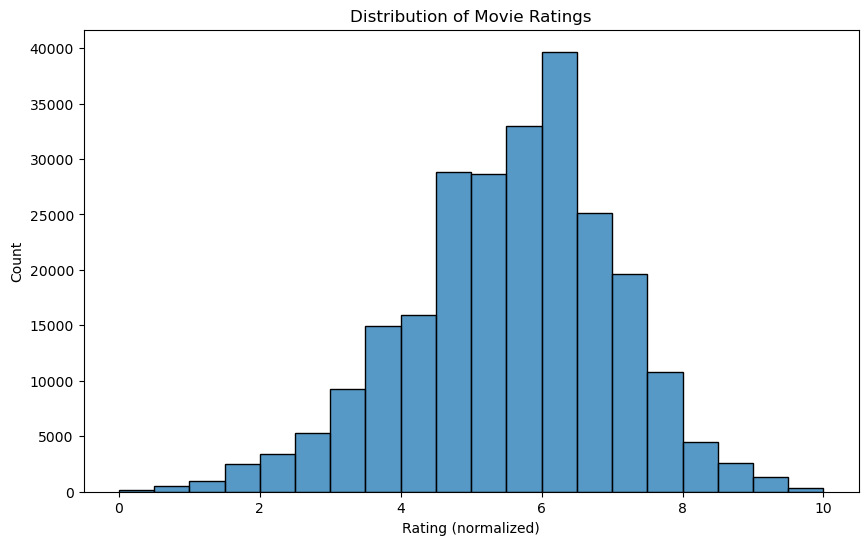

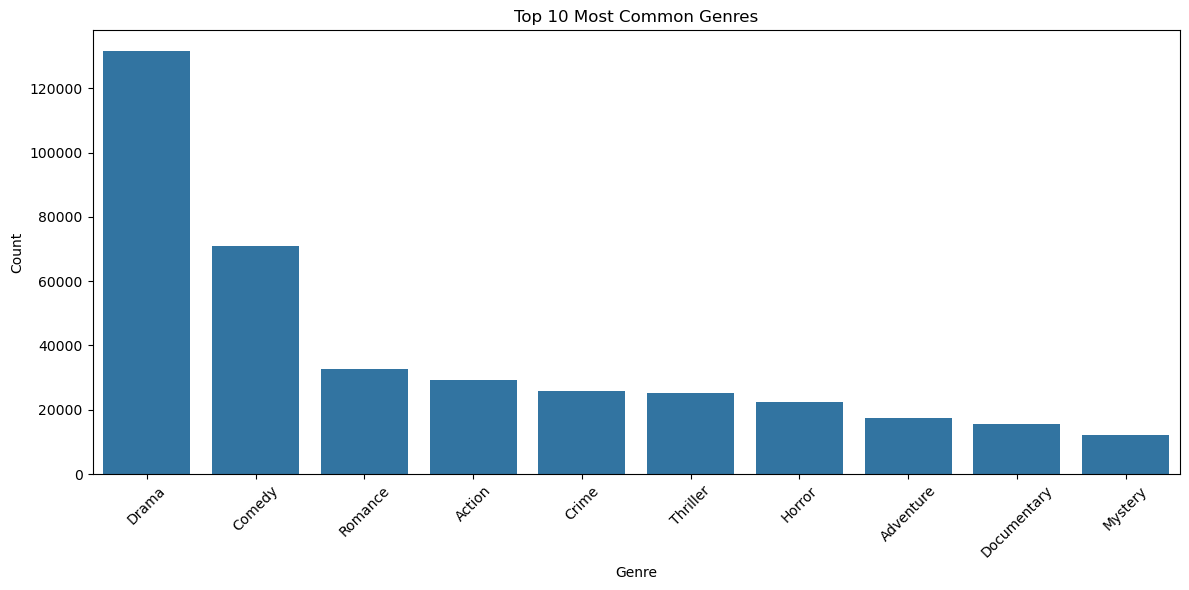

In [4]:
# Cell 4: Visualize some statistics
# Plot distribution of movie ratings
plt.figure(figsize=(10, 6))
sns.histplot(movies_df['Rating'] * 10, bins=20)  # Multiplying by 10 to convert normalized values
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating (normalized)')
plt.ylabel('Count')
plt.show()

# Plot most common genres
all_genres = [genre for genres_list in movies_df['Genres'].dropna() for genre in genres_list]
genre_counts = pd.Series(all_genres).value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title('Top 10 Most Common Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
def extract_movie_features(movie, genre_encoder, director_encoder, cast_encoder):
    features = []
    
    # Numeric features
    features.extend([
        movie['Year'],
        movie['RunningTime'],
        movie['Rating'],
        movie['Votes']
    ])
    
    # Encoded genres (taking first 3 or padding with -1)
    genres = movie['Genres'][:3] if len(movie['Genres']) >= 3 else movie['Genres'] + [''] * (3 - len(movie['Genres']))
    genre_codes = [genre_encoder.transform([g])[0] if g else -1 for g in genres]
    features.extend(genre_codes)
    
    # Encoded directors (taking first 2 or padding with -1)
    directors = movie['Director'][:2] if len(movie['Director']) >= 2 else movie['Director'] + [''] * (2 - len(movie['Director']))
    director_codes = [director_encoder.transform([d])[0] if d else -1 for d in directors]
    features.extend(director_codes)
    
    # Encoded cast (taking first 3 or padding with -1)
    cast = movie['Cast'][:3] if len(movie['Cast']) >= 3 else movie['Cast'] + [''] * (3 - len(movie['Cast']))
    cast_codes = [cast_encoder.transform([c])[0] if c and pd.notna(c) else -1 for c in cast]
    features.extend(cast_codes)
    
    return features

In [6]:
movies_df.head()

,ID,Title,Year,Genres,Director,Cast,RunningTime,Rating,Votes
0,tt0000009,Miss Jerry,0.000000,[Romance],[Alexander Black],"[Blanche Bayliss, William Courtenay, Chaunce...",0.001019,0.477778,0.000072
3,tt0000574,The Story of the Kelly Gang,0.091603,"[Action, Adventure, Biography]",[Charles Tait],"[Elizabeth Tait, John Tait, Nicholas Brierle...",0.001597,0.555556,0.000322
4,tt0000591,The Prodigal Son,0.099237,[Drama],[Michel Carré],"[Georges Wague, Henri Gouget, Christiane Man...",0.002060,0.511111,0.000009
8,tt0000679,The Fairylogue and Radio-Plays,0.106870,"[Adventure, Fantasy]","[Otis Turner, Francis Boggs]","[L. Frank Baum, Frank Burns, Frank Burns, G...",0.002755,0.466667,0.000024
20,tt0000941,Locura de amor,0.114504,[Drama],"[Alberto Marro, Ricardo de Baños]","[José Argelagués, Joaquín Carrasco, José Dur...",0.001019,0.400000,0.000008


In [7]:
user_history_df.head()

,ID,Title,Year,Genres,Director,Cast,RunningTime,Rating,Votes,Liked/Disliked
0,tt0407887,The Departed,2006,"Crime,Drama,Thriller",Martin Scorsese,"Leonardo DiCaprio, Matt Damon, Jack Nicholson,...",151,8.5,1474813,liked
1,tt0111161,The Shawshank Redemption,1994,Drama,Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",142,9.3,3014260,liked
2,tt1375666,Inception,2010,"Action,Adventure,Sci-Fi",Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...",148,8.8,2657851,liked
3,tt0112384,Apollo 13,1995,"Adventure,Drama,History",Ron Howard,"Tom Hanks, Bill Paxton, Kevin Bacon, Gary Sini...",140,7.7,324490,liked
4,tt15398776,Oppenheimer,2023,"Biography,Drama,History",Christopher Nolan,"Cillian Murphy, Emily Blunt, Matt Damon, Rober...",180,8.3,860004,liked


In [8]:
# Cell 5: Create user sequences for training
def create_user_sequences(user_history_df, movies_df, genre_encoder, director_encoder, cast_encoder, seq_length):
    # Since we don't have user IDs, we'll treat the entire watched list as a single user's sequence
    # Sort by some order (you might want to add a timestamp or use the order in the dataset)
    
    # Add a sequence number if not already present
    if 'Sequence' not in user_history_df.columns:
        user_history_df['Sequence'] = range(len(user_history_df))
    
    user_history_df.head()
    
    sequences = []
    labels = []
    
    # Create sequences
    for i in range(len(user_history_df) - seq_length):
        seq = user_history_df.iloc[i:i+seq_length]
        next_movie = user_history_df.iloc[i+seq_length]
        
        # Get movie features for sequence
        seq_features = []
        for _, movie_entry in seq.iterrows():
            movie_id = movie_entry['ID']
            print(movie_entry)
            movie_data = movies_df[movies_df['ID'] == movie_id]
            
            # Skip if movie not found in movies_df
            if len(movie_data) == 0:
                print(f"Warning: Movie ID {movie_id} ('{movie_entry['Title']}') not found in movies_df.")
                continue
                
            movie_data = movie_data.iloc[0]
            movie_features = extract_movie_features(movie_data, genre_encoder, director_encoder, cast_encoder)

            if movie_features is None or len(movie_features) == 0:
                print(f"Warning: Features not extracted for movie ID {movie_id}.")
                continue

            seq_features.append(movie_features)
        
        # Skip if we couldn't get features for all movies in the sequence
        if len(seq_features) != seq_length:
            continue
        
        # Get label (liked/disliked)
        # Adjust based on your actual data format
        liked_column = 'Liked/Disliked'
        if next_movie[liked_column] == 'liked':
            label = 1
        elif next_movie[liked_column] == 'disliked':
            label = 0
        else:
            print(f"Warning: Invalid value in 'Liked/Disliked' column for movie ID {next_movie['ID']}.")
            continue
        
        sequences.append(seq_features)
        labels.append(label)
    
    # Check if we have any valid sequences
    if len(sequences) == 0:
        print("No valid sequences found.")
        return np.array([]), np.array([])
    
    return np.array(sequences), np.array(labels)

In [9]:
# Cell 6: Create training sequences
# Set sequence length
seq_length = 1

# Create sequences for training
X, y = create_user_sequences(user_history_df, movies_df, genre_encoder, director_encoder, cast_encoder, seq_length)

if len(X) == 0:
    print("No valid sequences generated. Check your data and sequence length.")
else:
    print(f"Generated {len(X)} training sequences")
    print(f"Sequence shape: {X.shape}")
    print(f"Labels shape: {y.shape}")
    print(f"Positive examples (liked): {sum(y)} ({sum(y)/len(y)*100:.2f}%)")
    print(f"Negative examples (disliked): {len(y)-sum(y)} ({(len(y)-sum(y))/len(y)*100:.2f}%)")

ID                                                        tt0407887
Title                                                  The Departed
Year                                                           2006
Genres                                         Crime,Drama,Thriller
Director                                            Martin Scorsese
Cast              Leonardo DiCaprio, Matt Damon, Jack Nicholson,...
RunningTime                                                     151
Rating                                                          8.5
Votes                                                       1474813
Liked/Disliked                                                liked
Sequence                                                          0
Name: 0, dtype: object
ID                                                        tt0111161
Title                                      The Shawshank Redemption
Year                                                           1994
Genres                   

In [10]:
# Cell 7: Build LSTM model
def build_lstm_model(input_shape, lstm_units=64):
    model = Sequential([
        LSTM(lstm_units, input_shape=input_shape, return_sequences=True),
        Dropout(0.3),
        LSTM(lstm_units // 2),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    # Print model summary
    model.summary()
    
    return model

In [11]:
# Cell 9: Split data and build model
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=0)

# Get input shape
input_shape = (X_train.shape[1], X_train.shape[2])
print(f"Input shape: {input_shape}")

# Build model
model = build_lstm_model(input_shape)

Input shape: (1, 12)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             19712     
                                                                 
 dropout (Dropout)           (None, 1, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 33,217
Trainable para

2025-03-07 08:33:12.946850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-07 08:33:12.947294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-07 08:33:12.947919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [12]:
# Cell 10: Train model
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50


2025-03-07 08:33:13.076343: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2025-03-07 08:33:13.366895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-07 08:33:13.367434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-07 08:33:13.367942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG IN

1/1 [==============================] - ETA: 0s - loss: 0.6821 - accuracy: 0.6316

2025-03-07 08:33:14.732434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-07 08:33:14.732942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-07 08:33:14.733419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 2s 2s/step - loss: 0.6821 - accuracy: 0.6316 - val_loss: 0.6805 - val_accuracy: 0.8000
Epoch 2/50
1/1 [==============================] - 0s 17ms/step - loss: 0.6795 - accuracy: 0.6316 - val_loss: 0.6758 - val_accuracy: 0.8000
Epoch 3/50
1/1 [==============================] - 0s 17ms/step - loss: 0.6691 - accuracy: 0.7368 - val_loss: 0.6714 - val_accuracy: 0.8000
Epoch 4/50
1/1 [==============================] - 0s 15ms/step - loss: 0.6554 - accuracy: 0.8421 - val_loss: 0.6669 - val_accuracy: 0.8000
Epoch 5/50
1/1 [==============================] - 0s 16ms/step - loss: 0.6564 - accuracy: 0.8421 - val_loss: 0.6628 - val_accuracy: 0.8000
Epoch 6/50
1/1 [==============================] - 0s 16ms/step - loss: 0.6449 - accuracy: 0.9474 - val_loss: 0.6548 - val_accuracy: 0.8000
Epoch 7/50
1/1 [==============================] - 0s 16ms/step - loss: 0.6424 - accuracy: 0.9474 - val_loss: 0.6503 - val_accuracy: 0.8000
Epoch 8/50
1/1 [========================

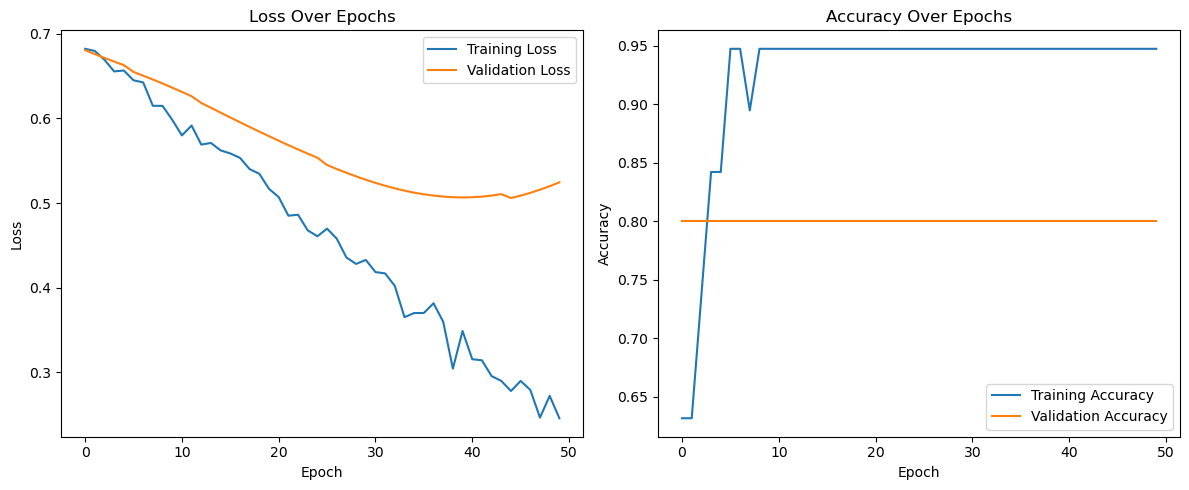

1/1 [==============================] - 0s 14ms/step - loss: 0.5059 - accuracy: 0.8000
Test Loss: 0.5059
Test Accuracy: 0.8000


In [13]:
# Cell 11: Evaluate model
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


In [14]:
# Pre-compute all movie features and store them
def precompute_movie_features(movies_df, genre_encoder, director_encoder, cast_encoder):
    movie_features_dict = {}
    for _, movie in movies_df.iterrows():
        movie_id = movie['ID']
        features = extract_movie_features(movie, genre_encoder, director_encoder, cast_encoder)
        movie_features_dict[movie_id] = features
    return movie_features_dict

# Then use pre-computed features in your recommendation function

In [15]:
def generate_recommendations_optimized(user_history_df, movies_df, model,
                                      precomputed_features, 
                                      num_recommendations=5, seq_length=1):
    # Get recent movie history for user
    user_movies = user_history_df
    
    if len(user_movies) < seq_length:
        return "Not enough watch history to generate recommendations"
    
    # Get latest sequence using precomputed features
    latest_seq = user_movies.iloc[-seq_length:]
    seq_features = []
    
    for _, movie in latest_seq.iterrows():
        movie_id = movie['ID']
        # Use precomputed features instead of extracting again
        if movie_id in precomputed_features:
            seq_features.append(precomputed_features[movie_id])
        else:
            # Fallback if somehow movie is missing from precomputed features
            movie_data = movies_df[movies_df['ID'] == movie_id].iloc[0]
            movie_features = extract_movie_features(movie_data, genre_encoder, director_encoder, cast_encoder)
            seq_features.append(movie_features)
    
    # Get all movies the user hasn't watched
    watched_movie_ids = user_movies['ID'].unique()
    
    # Calculate prediction scores for unwatched movies in batches
    recommendations = []
    batch_size = 1000  # Process movies in batches of 1000
    
    # Get the IDs of unwatched movies with precomputed features
    unwatched_movie_ids = [mid for mid in precomputed_features.keys() if mid not in watched_movie_ids]
    
    # If too many movies, sample a subset
    if len(unwatched_movie_ids) > 10000:
        import random
        unwatched_movie_ids = random.sample(unwatched_movie_ids, 10000)
    
    # Process in batches
    for i in range(0, len(unwatched_movie_ids), batch_size):
        batch_ids = unwatched_movie_ids[i:i+batch_size]
        
        # Prepare batch input for model
        batch_inputs = []
        for movie_id in batch_ids:
            # Create a new sequence with the candidate movie
            candidate_features = precomputed_features[movie_id]
            new_seq = seq_features[1:] + [candidate_features] if len(seq_features) > 1 else [candidate_features]
            batch_inputs.append(new_seq)
        
        # Convert to numpy array and predict
        batch_inputs = np.array(batch_inputs, dtype=np.float32)
        batch_scores = model.predict(batch_inputs, verbose=0).flatten()
        
        # Get movie details and add to recommendations
        for j, movie_id in enumerate(batch_ids):
            movie_data = movies_df[movies_df['ID'] == movie_id]
            if not movie_data.empty:
                title = movie_data.iloc[0]['Title']
                score = float(batch_scores[j])
                recommendations.append((movie_id, title, score))
    
    # Sort by prediction score and get top recommendations
    recommendations.sort(key=lambda x: x[2], reverse=True)
    top_recommendations = recommendations[:num_recommendations]
    
    return top_recommendations

In [ ]:
# Cell 13: Generate recommendations for a user
# Step 1: Precompute all movie features once (do this at startup)
def precompute_movie_features(movies_df, genre_encoder, director_encoder, cast_encoder):
    print("Precomputing features for all movies...")
    movie_features_dict = {}
    for _, movie in movies_df.iterrows():
        movie_id = movie['ID']
        features = extract_movie_features(movie, genre_encoder, director_encoder, cast_encoder)
        movie_features_dict[movie_id] = features
    print(f"Precomputed features for {len(movie_features_dict)} movies")
    return movie_features_dict

# Step 2: Run the precomputation once
precomputed_features = precompute_movie_features(movies_df, genre_encoder, director_encoder, cast_encoder)

# Step 3: Generate recommendations using the optimized function
user_id = 1
recommendations = generate_recommendations_optimized(
    user_history_df, 
    movies_df, 
    model,
    precomputed_features
)

# Step 4: Display recommendations
if isinstance(recommendations, str):
    print(recommendations)
else:
    print(f"Top recommendations for user {user_id}:")
    for movie_id, title, score in recommendations:
        print(f"{title} (ID: {movie_id}) - Score: {score:.4f}")

Precomputing features for all movies...
